## Import Libraries

In [1]:
!pip install torch-geometric

import os
import numpy as np
import pyarrow as pa
import pandas as pd
import pyarrow.parquet as pq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:0000:01


## Disable Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Load the Data

In [3]:
def read_file(path):
  chunk_size = 25

# Create a Parquet file reader object
  parquet_file = pq.ParquetFile(path)

# Determine the total number of rows in the file
  total_rows = parquet_file.metadata.num_rows

# Loop over the file in chunks
  data = []
  for i in range(0, total_rows, chunk_size):
    # Read a chunk of rows from the file
      chunk = (parquet_file.read_row_group(i))
      dm = (chunk.to_pandas())
      data.append(dm)

# Concatenate all the DataFrames into a single DataFrame
  df = pd.concat(data, ignore_index=True)
  print(parquet_file.read_row_group(0).to_pandas())
  return df

In [4]:
df1 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run0.test.snappy.parquet')
df2 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run1.test.snappy.parquet')
df3 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run2.test.snappy.parquet')

                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  112.411095  21.098248   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  147.686737  32.114449   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  107.854118  18.723455   

     y  
0  0.0  


In [5]:
def construct_image_dataset(df):
    # Get the total number of samples
    num_samples = len(df)

    # Initialize empty arrays for X and y
    X = np.empty((num_samples, 3, 125, 125), dtype=np.float32)
    y = np.empty(num_samples, dtype=int)

    # Iterate through the DataFrame and fill X and y
    for i, row in df.iterrows():
        # Stack the three channels of X_jets and transpose them to match the desired shape
        X[i] = np.transpose(np.dstack((np.stack(row['X_jets'][0]), np.stack(row['X_jets'][1]), np.stack(row['X_jets'][2]))), (2, 0, 1))
        # Assign the label to y
        y[i] = row['y']

    # Rearrange the dimensions of X to match the TensorFlow format (samples, height, width, channels)
    X = np.transpose(X, (0, 2, 3, 1))

    return X, y

In [6]:
# Assuming 'df' is the pandas DataFrame
X1, y1 = construct_image_dataset(df1)
X2, y2 = construct_image_dataset(df2)
X3, y3 = construct_image_dataset(df3)

In [7]:
# Save X1 array to binary file 'X1.npy'
with open('X1.npy', 'wb') as f:
    np.save(f, X1)

# Save y1 array to binary file 'y1.npy'
with open('y1.npy', 'wb') as f:
    np.save(f, y1)

# Save X2 array to binary file 'X2.npy'
with open('X2.npy', 'wb') as f:
    np.save(f, X2)

# Save y2 array to binary file 'y2.npy'
with open('y2.npy', 'wb') as f:
    np.save(f, y2)

# Save X3 array to binary file 'X3.npy'
with open('X3.npy', 'wb') as f:
    np.save(f, X3)

# Save y3 array to binary file 'y3.npy'
with open('y3.npy', 'wb') as f:
    np.save(f, y3)

In [8]:
x1 = np.load('X1.npy')
x2 = np.load('X2.npy')
x3 = np.load('X3.npy')

y1 = np.load('y1.npy')
y2 = np.load('y2.npy')
y3 = np.load('y3.npy')

In [9]:
# Combine x arrays along the first axis (axis=0)
x = np.concatenate((x1, x2, x3), axis=0)

# Combine y arrays along the first axis (axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

# Save the combined X array to a binary file named 'X.npy'
with open('x.npy', 'wb') as f:
    np.save(f, x)

# Save the combined y array to a binary file named 'y.npy'
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [10]:
X = np.load("x.npy")
y = np.load("y.npy")

### Convert the numpy arrays to PyTorch tensors

In [11]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int)

In [12]:
def linear_kernel(distance_matrix, gamma=None):
    if gamma is None:
        gamma = 1.0 / distance_matrix.shape[1]
    return gamma * np.dot(distance_matrix, gamma)

In [13]:
def construct_graph_using_linear_kernel(image, label):
    height, width, channels = image.shape
    nodes = []
    positions = []

    # Iterate over the 5x5 crops and extract features
    for i in range(0, height, 5):
        for j in range(0, width, 5):
            crop = image[i:i+5, j:j+5]
            feature = crop.reshape(-1)
            nodes.append(feature)
            positions.append((i, j))

    nodes = torch.stack(nodes)
    positions = np.array(positions)

    # Compute edge_index and edge_attr using Linear Kernel
    distance_matrix = cdist(positions, positions)
    linear_values = linear_kernel(distance_matrix)
    edges = np.where(linear_values > 0.8)  # Adjust threshold as needed
    edge_index = torch.tensor(np.vstack(edges), dtype=torch.long)
    edge_attr = torch.tensor(linear_values[edges], dtype=torch.float)

    # Create the PyTorch Geometric Data object
    data = Data(x=nodes, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([label], dtype=torch.long))
    return data

In [14]:
filename = "pyg_data_list.pkl"
if os.path.exists(filename):
    print(f"{filename} exists in the current directory.")
    with open("pyg_data_list.pkl", "rb") as file:
        pyg_data_list = pickle.load(file)
else:
    print(f"{filename} does not exist in the current directory.")
    # Create PyTorch Geometric Data objects for each image
    pyg_data_list = [construct_graph_using_linear_kernel(X[i], y[i]) for i in tqdm(range(X.shape[0]), desc="Creating Data Objects")]

pyg_data_list.pkl does not exist in the current directory.


Creating Data Objects: 100%|██████████| 5573/5573 [01:22<00:00, 67.35it/s]


## Set up the train and test datasets

In [15]:
train_dataset = pyg_data_list[:int(len(pyg_data_list) * 0.75)]
test_dataset = pyg_data_list[int(len(pyg_data_list) * 0.75):]

## Set up the data loader

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Building GCN Model

In [17]:
class GCNModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return x

## Set up the GCN model, loss function, and optimizer

In [18]:
num_node_features = train_dataset[0].x.shape[1]
hidden_channels = 64
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNModel(num_node_features, hidden_channels, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Define training and evaluation functions

In [19]:
def train():
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad() # To Clear gradients
        out = model(data) # Perform a single forward pass
        loss = criterion(out, data.y) # Compute the loss
        loss.backward() # Deriving gradients
        optimizer.step() # Updating parameters
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    y_true = []
    y_probs = []

    for data in tqdm(loader, desc="Testing"):
        data = data.to(device)
        with torch.no_grad():
            logits = model(data)
        probs = F.softmax(logits, dim=-1)
        pred = logits.argmax(dim=-1)

        y_true.extend(data.y.tolist())
        y_probs.extend(probs[:, 1].tolist())

        correct += int((pred == data.y).sum())

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    accuracy = correct / len(loader.dataset)

    return accuracy, fpr, tpr, roc_auc

## Function to plot the ROC curve

In [20]:
def plot_roc_curve(false_pr, true_pr, roc_auc, title="ROC curve"):
    plt.figure(figsize = (10, 10))
    plt.plot(false_pr, true_pr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="-.")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig("gcn-roc-curve.png")
    plt.show()

Testing: 100%|██████████| 44/44 [00:00<00:00, 134.54it/s]


Epoch: 1, Loss: 0.6931, Train (Accuracy): 0.5085, Train (ROC-AUC): 0.6358, Test (Accuracy): 0.5100, Test (ROC-AUC): 0.6218


Testing: 100%|██████████| 44/44 [00:00<00:00, 116.74it/s]


Epoch: 2, Loss: 0.6919, Train (Accuracy): 0.5781, Train (ROC-AUC): 0.6691, Test (Accuracy): 0.5703, Test (ROC-AUC): 0.6602


Testing: 100%|██████████| 44/44 [00:00<00:00, 127.42it/s]


Epoch: 3, Loss: 0.6863, Train (Accuracy): 0.5970, Train (ROC-AUC): 0.6801, Test (Accuracy): 0.5875, Test (ROC-AUC): 0.6679


Testing: 100%|██████████| 44/44 [00:00<00:00, 129.65it/s]


Epoch: 4, Loss: 0.6705, Train (Accuracy): 0.6365, Train (ROC-AUC): 0.6947, Test (Accuracy): 0.6155, Test (ROC-AUC): 0.6766


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.25it/s]


Epoch: 5, Loss: 0.6547, Train (Accuracy): 0.6557, Train (ROC-AUC): 0.7152, Test (Accuracy): 0.6370, Test (ROC-AUC): 0.6901


Testing: 100%|██████████| 44/44 [00:00<00:00, 129.08it/s]


Epoch: 6, Loss: 0.6432, Train (Accuracy): 0.6655, Train (ROC-AUC): 0.7278, Test (Accuracy): 0.6385, Test (ROC-AUC): 0.6984


Testing: 100%|██████████| 44/44 [00:00<00:00, 144.40it/s]


Epoch: 7, Loss: 0.6341, Train (Accuracy): 0.6779, Train (ROC-AUC): 0.7360, Test (Accuracy): 0.6499, Test (ROC-AUC): 0.7066


Testing: 100%|██████████| 44/44 [00:00<00:00, 142.06it/s]


Epoch: 8, Loss: 0.6269, Train (Accuracy): 0.6829, Train (ROC-AUC): 0.7457, Test (Accuracy): 0.6420, Test (ROC-AUC): 0.7115


Testing: 100%|██████████| 44/44 [00:00<00:00, 131.36it/s]


Epoch: 9, Loss: 0.6199, Train (Accuracy): 0.6870, Train (ROC-AUC): 0.7532, Test (Accuracy): 0.6463, Test (ROC-AUC): 0.7152


Testing: 100%|██████████| 44/44 [00:00<00:00, 123.37it/s]


Epoch: 10, Loss: 0.6134, Train (Accuracy): 0.6994, Train (ROC-AUC): 0.7572, Test (Accuracy): 0.6593, Test (ROC-AUC): 0.7195


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.94it/s]


Epoch: 11, Loss: 0.6084, Train (Accuracy): 0.7028, Train (ROC-AUC): 0.7616, Test (Accuracy): 0.6542, Test (ROC-AUC): 0.7230


Testing: 100%|██████████| 44/44 [00:00<00:00, 133.01it/s]


Epoch: 12, Loss: 0.6024, Train (Accuracy): 0.7073, Train (ROC-AUC): 0.7667, Test (Accuracy): 0.6578, Test (ROC-AUC): 0.7259


Testing: 100%|██████████| 44/44 [00:00<00:00, 132.75it/s]


Epoch: 13, Loss: 0.5982, Train (Accuracy): 0.7121, Train (ROC-AUC): 0.7703, Test (Accuracy): 0.6643, Test (ROC-AUC): 0.7301


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.32it/s]


Epoch: 14, Loss: 0.5974, Train (Accuracy): 0.7150, Train (ROC-AUC): 0.7746, Test (Accuracy): 0.6628, Test (ROC-AUC): 0.7324


Testing: 100%|██████████| 44/44 [00:00<00:00, 136.96it/s]


Epoch: 15, Loss: 0.5928, Train (Accuracy): 0.6956, Train (ROC-AUC): 0.7809, Test (Accuracy): 0.6492, Test (ROC-AUC): 0.7297


Testing: 100%|██████████| 44/44 [00:00<00:00, 131.58it/s]


Epoch: 16, Loss: 0.5880, Train (Accuracy): 0.7207, Train (ROC-AUC): 0.7822, Test (Accuracy): 0.6664, Test (ROC-AUC): 0.7320


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.02it/s]


Epoch: 17, Loss: 0.5875, Train (Accuracy): 0.7246, Train (ROC-AUC): 0.7848, Test (Accuracy): 0.6750, Test (ROC-AUC): 0.7351


Testing: 100%|██████████| 44/44 [00:00<00:00, 137.70it/s]


Epoch: 18, Loss: 0.5850, Train (Accuracy): 0.7246, Train (ROC-AUC): 0.7907, Test (Accuracy): 0.6686, Test (ROC-AUC): 0.7364


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.81it/s]


Epoch: 19, Loss: 0.5825, Train (Accuracy): 0.7231, Train (ROC-AUC): 0.7932, Test (Accuracy): 0.6686, Test (ROC-AUC): 0.7367


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.65it/s]


Epoch: 20, Loss: 0.5736, Train (Accuracy): 0.7279, Train (ROC-AUC): 0.7944, Test (Accuracy): 0.6786, Test (ROC-AUC): 0.7396


Testing: 100%|██████████| 44/44 [00:00<00:00, 114.23it/s]


Epoch: 21, Loss: 0.5792, Train (Accuracy): 0.7227, Train (ROC-AUC): 0.8002, Test (Accuracy): 0.6628, Test (ROC-AUC): 0.7354


Testing: 100%|██████████| 44/44 [00:00<00:00, 134.58it/s]


Epoch: 22, Loss: 0.5706, Train (Accuracy): 0.7363, Train (ROC-AUC): 0.7993, Test (Accuracy): 0.6679, Test (ROC-AUC): 0.7406


Testing: 100%|██████████| 44/44 [00:00<00:00, 135.77it/s]


Epoch: 23, Loss: 0.5695, Train (Accuracy): 0.7289, Train (ROC-AUC): 0.8053, Test (Accuracy): 0.6729, Test (ROC-AUC): 0.7372


Testing: 100%|██████████| 44/44 [00:00<00:00, 128.81it/s]


Epoch: 24, Loss: 0.5644, Train (Accuracy): 0.7358, Train (ROC-AUC): 0.8088, Test (Accuracy): 0.6729, Test (ROC-AUC): 0.7376


Testing: 100%|██████████| 44/44 [00:00<00:00, 131.81it/s]


Epoch: 25, Loss: 0.5593, Train (Accuracy): 0.7449, Train (ROC-AUC): 0.8091, Test (Accuracy): 0.6729, Test (ROC-AUC): 0.7388


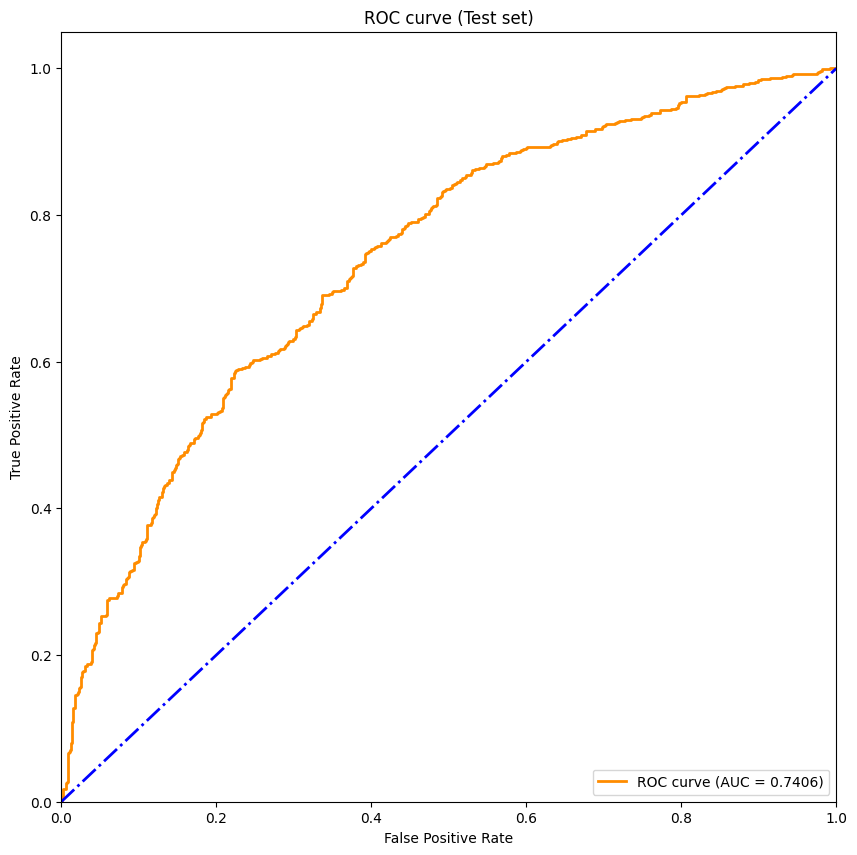

In [21]:
num_epochs = 25
max_auc = 0

for epoch in range(num_epochs):
    loss = train()
    train_acc, _, _, train_roc_auc = test(train_loader)
    test_acc, false_pr, true_pr, test_roc_auc = test(test_loader)
    print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Train (Accuracy): {train_acc:.4f}, Train (ROC-AUC): {train_roc_auc:.4f}, Test (Accuracy): {test_acc:.4f}, Test (ROC-AUC): {test_roc_auc:.4f}")
    if test_roc_auc > max_auc:
        max_auc = test_roc_auc
        max_false_pr, max_true_pr, = false_pr, true_pr

plot_roc_curve(max_false_pr, max_true_pr, max_auc, title="ROC curve (Test set)")